# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm! 




## Structure of the project. 

- `task.py`: Define task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: sample agent.
    - `agent.py`: Develop own agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

Task is defined in `task.py`.  

Reinforcement learning agent is implemented in `agent.py`.  


## Controlling the Quadcopter
 `agents/policy_search.py`

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  


In [40]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Below code allow agent to select actions to control the quadcopter.  


The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [41]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Visualize how the position of the quadcopter evolved during the simulation.

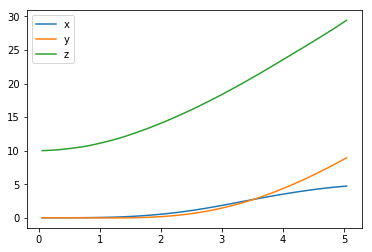

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

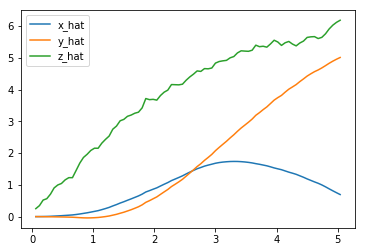

In [43]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

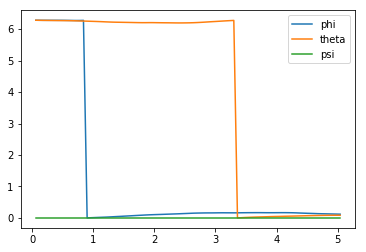

In [44]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

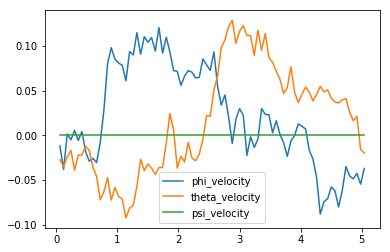

In [45]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, Print the agent's choice of actions.  

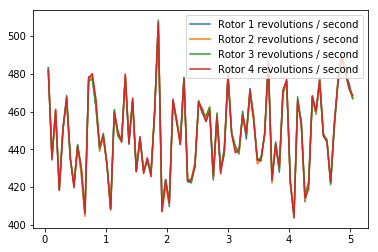

In [46]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, derive the environment state from the simulator.  Print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [47]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[  4.71728339   8.93715303  29.43419893   0.11849271   0.08364226   0.        ]
[ 0.69487327  5.01108803  6.18367582]
[-0.03703078 -0.01976636  0.        ]



## The Task


The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, I have used action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- I set the number of elements in the state vector.  For the sample task, I only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), I must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). It is possible to set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Below code will demonstrate how the agent performs on the sample task.

In [48]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =   6.746 (best =  37.562), noise_scale = 3.255

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train  Agent!

`task.py` is for specifying a task of mu choice.  I can teach my quadcopter to takeoff, hover in place, land softly, or reach a target pose.  


In [50]:
import sys
import pandas as pd
import csv
import numpy as np
from agents.agent import DDPG
from task import Task

# HOVER TASK

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'rewards.txt'                      # file name for saved results

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos, init_pose=init_pose)
agent = DDPG(task) 

labels = ['episod', 'total_reward']
results = {x : [] for x in labels}

with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)  
    best_total_reward = 0
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        total_reward = 0
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            total_reward += reward
            if total_reward > best_total_reward:
                best_total_reward = total_reward
            agent.step(action, reward, next_state, done)
            state = next_state
            if done:
                to_write = [i_episode] + [total_reward]
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, total_reward = {:7.3f} (best = {:7.3f})".format(
                    i_episode, total_reward, best_total_reward), end="")
                break
        sys.stdout.flush()


Episode = 1000, total_reward = 147.481 (best = 10256.757)))

In [55]:
# training agent in this box
import csv
import pandas as pd 
import sys
import numpy as np
from task import Task
from agents.agent import DDPG

# TAKE OFF TASK

runtime = 5.                                     # time limit of the episode
# initial pose for landing task, copter is at some height h.
init_pose = np.array([0., 0., 0., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'rewards.txt'                         # file name for saved results
episodes = 1000                                 # number of episodes
target_pos = np.array([0., 0., 10.])             # target position
done = False

# Setup in case of DDPG agent 
task = Task(target_pos = target_pos)
agent = DDPG(task)
labels = ['episod', 'score', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
         'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity', 
         'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']

results = {x : [] for x in labels}

# Running the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    best_total_reward = 0
    for i in range(1, episodes+1):
        state = agent.reset_episode()
        total_reward = 0
        while True:
            action = agent.act(state)
            next_state, reward, done = task.step(action)
            total_reward += reward
            if total_reward > best_total_reward:
                best_total_reward = total_reward
            agent.step(action, reward, next_state, done)
            state = next_state
            if done:
                to_write = [i] + [total_reward]
                to_write = [i, total_reward] + \
                                list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, total_reward = {:7.3f} (best = {:7.3f})".format(
                    i, total_reward, best_total_reward), end="")
                break
        sys.stdout.flush()


Episode = 1000, total_reward = 12085.971 (best = 68185.851)

## Ploting the Rewards

Once performance reached a certain level, I ploted the episode rewards, either from a single run, or averaged over multiple runs. 

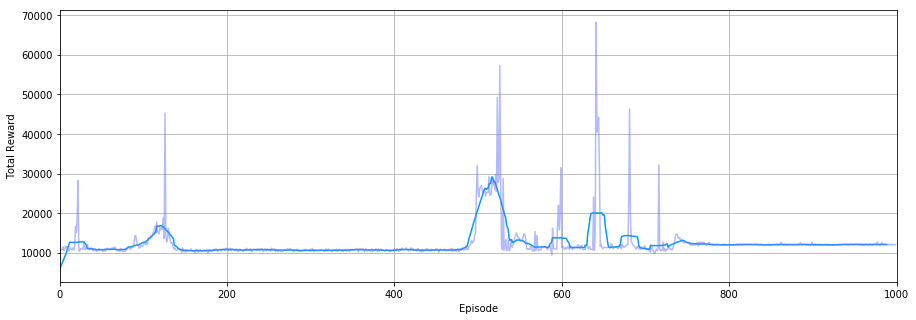

In [56]:

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

smooth = 21
plt.figure(figsize=(15, 5))
plt.plot(np.convolve(results['score'], np.ones(smooth)/smooth)[(smooth-1)//2:-smooth], color='xkcd:azure')
plt.plot(results['score'], alpha=0.5, color='xkcd:cornflower')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.xlim(0, len(results['score']))
plt.grid(True)
plt.show()

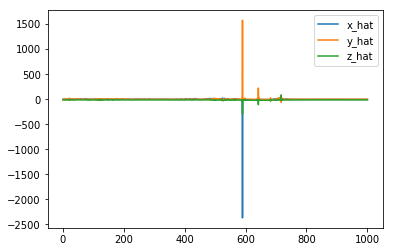

In [57]:
#visualizes the velocity of the quadcopter
plt.plot(results['episod'], results['x_velocity'], label='x_hat')
plt.plot(results['episod'], results['y_velocity'], label='y_hat')
plt.plot(results['episod'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

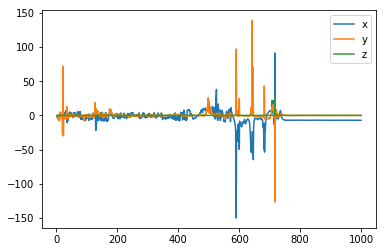

In [58]:
#visualizes the x,y,z co-ordinates of the quadcopter
plt.plot(results['episod'], results['x'], label='x')
plt.plot(results['episod'], results['y'], label='y')
plt.plot(results['episod'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

## Reflections

**Note 1**: Describe the task in `task.py`.  How I have design the reward function?

**Answer**: 

I devided the task in 2 part. Hovering and Takeoff.

For both the task the reward function is 1. - .2*(abs(self.sim.pose[:3] - self.target_pos)).sum(), along with clipping of rewards to make it stay between +1 and -1. 

However, there is more reward if the agent fly in the z direction. And if the agent reached a certain height then there is bonus reward of 50.

**Note 2**: Discuss agent briefly

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**: 

I used a neural network with different layers.

**NN architecture for  Actor class**

Dense(hidden_units = 32, regularizer_l2 = 0.01, activity_regularizer = 0.01)
Batch_normalization()
Activation(relu)
Dropout(keep_prob = 0.5)

Dense(hidden_units = 64, regularizer_l2 = 0.01, activity_regularizer = 0.01)
Batch_normalization()
Activation(relu)
Dropout(keep_prob = 0.5)

Dense(hidden_units = 128, regularizer_l2 = 0.01, activity_regularizer = 0.01)
Batch_normalization()
Activation(relu)
Dropout(keep_prob = 0.5)

Dense(hidden_units = 64, regularizer_l2 = 0.01, activity_regularizer = 0.01)
Batch_normalization()
Activation(relu)
Dropout(keep_prob = 0.5)

Dense(hidden_units = action_size, activation = sigmoid)
'''

**NN architecture for Critic class**

<font color = 'green'>State: </font>

Dense(hidden_units = 32, regularizer_l2 = 0.01, activity_regularizer = 0.01) -- Batch_normalization() -- Activation(relu) -- Dropout(keep_prob = 0.5)

Dense(hidden_units = 64, regularizer_l2 = 0.01, activity_regularizer = 0.01) -- Batch_normalization() -- Activation(relu) -- Dropout(keep_prob = 0.5)

Dense(hidden_units = 128, regularizer_l2 = 0.01, activity_regularizer = 0.01) -- Batch_normalization() -- Activation(relu) -- Dropout(keep_prob = 0.5)

<font color='green'>Action:</font>

Dense(hidden_units = 64, regularizer_l2 = 0.01, activity_regularizer = 0.01) -- Batch_normalization() -- Activation(relu) -- Dropout(keep_prob = 0.5)

Dense(hidden_units = 64, regularizer_l2 = 0.01, activity_regularizer = 0.01) -- Batch_normalization() -- Activation(relu) -- Dropout(keep_prob = 0.5)

Dense(hidden_units = 128, regularizer_l2 = 0.01, activity_regularizer = 0.01) -- Batch_normalization() -- Activation(relu) -- Dropout(keep_prob = 0.5)

Combined the action and states and applied a dense layer with relu activation.


**What is DDPG and why I have decided to use it?** </br>
Ans: I applied Deep Deterministic Policy Gradients (DDPG) over Deep Q Network (DQN). Because DDPG works on continuous state and action space whereas DQN is meant to solve discrete action space problems.

**What is the experience replay and what's the use of it?**  </br>
Ans: To perform experience replay we store the agent's experiences et=(st,at,rt,st+1)
This means instead of running Q-learning on state/action pairs as they occur during simulation or actual experience, the system stores the data discovered for [state, action, reward, next_state] - typically in a large table. Pointed to be noted is that, this does not store associated values - this is the raw data to feed into action-value calculations later. 

**Advantage:**  The Q-learning updates are incremental and do not converge quickly, so multiple passes with the same data is beneficial, especially when there is low variance in immediate outcomes (reward, next state) given the same state, action pair.


**What is the Fixed Q targets that I have implemented, the parameters that I have used like tau? How this technique helps.**  </br>

Ans: Deep Q-Learning was introduced in 2014. Since then, a lot of improvements have been made. One of the strategy to improvement is Fixed Q targets.

<font color='magenta'>Traditional Deep Q Learning: </font>
![Q_Learning](Q_Learning.png)

But we **don’t have any idea of the real TD target**. We need to estimate it. Using the Bellman equation, we know that TD target is just the reward of taking that action at that state plus the discounted highest Q value for the next state.
![Bellman](Q_Learning_Bellman.png)

However, the problem is that we using the same parameters (weights) for estimating the target and the Q value. As a consequence, there is a big correlation between the TD target and the parameters (w) we are changing.

Therefore, it means that at every step of training, **our Q values shift but also the target value shifts**. So, we’re getting closer to our target but the target is also moving. It’s like chasing a moving target! This lead to a big oscillation in training.

**Instead, we can use the idea of fixed Q-targets introduced by DeepMind:**

Using a separate network with a fixed parameter (let’s call it w-) for estimating the TD target.

At every Tau step, we copy the parameters from our DQN network to update the target network.

![fixed_Q_target](fixed_Q_target.png)



**Note 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: 

It was not an easy task to make the agent learn easily. It was quite tedious, training took a lot of time.

Often times I was not able to figure out when to stop the training as I was unsure of the possibility that agent might start learning.



**Note 4**: Briefly summarizing my experience working on this project. 

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did I find anything interesting in how the quadcopter or your agent behaved?

**Answer**: For me the hardest part was getting started. It took a lot of time to figure out what is it that I really want to achieve. After that changing the architecture of actor and critic class took most of my time. I had to set the right amount of layers for the agent to start learning.

For purely getting good performance, deep RL’s track record isn’t that great, because it consistently gets beaten by other methods. For example, online trajectory optimization worked better for "MuJoCo robots".

The rule-of-thumb is that except in rare cases, domain-specific algorithms work faster and better than reinforcement learning.

The main problem with RL is that it needs Reward function and it is really difficult to design a perfect reward function.

There are many algorithm that can work better than NN, like PID (Proportional Integral Derivative) or Linear Quadratic Regulator/Gaussian-LQR/G .
